<a href="https://colab.research.google.com/github/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis/blob/main/code/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you have access to a GPU. To do so, please do the followings:
1. Edit
2. Notebook settings
3. Select GPU for 'Hardware accelerator'
4. Save

You ready to go :-)

This practice presents the standard workflow to train a convolutional neural network (CNN) for image segmentation and detection. We will be playing with a dataset of images from "Where is Wally?". Let's see if CNN can help to find him.

## Step 0: Configuration

Some Python packages...

In [1]:
import os
import random
from PIL import Image
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

We will be using the tools from PyTorch for the Deep Learning aspects of the pipeline.

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader

Looking at the working directory before cloning the Github repository

In [3]:
pwd

'/content'

Cloning the Github repository and setting the working directory inside it

In [4]:
from google.colab import drive
drive.mount("/content/gdrive/")

path_github = "IMAS_MachineLearning_Workshop-Image_Analysis"
if not os.path.isdir(path_github):
    !git clone https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis.git

%cd IMAS_MachineLearning_Workshop-Image_Analysis/code/

!git fetch
!git pull origin main

Mounted at /content/gdrive/
Cloning into 'IMAS_MachineLearning_Workshop-Image_Analysis'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (428/428), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 428 (delta 163), reused 308 (delta 97), pack-reused 0
Receiving objects: 100% (428/428), 82.23 MiB | 10.24 MiB/s, done.
Resolving deltas: 100% (163/163), done.
/content/IMAS_MachineLearning_Workshop-Image_Analysis/code
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
 * branch            main       -> FETCH_HEAD
Already up to date.


Here after we are loading functions from the cloned Github repository, eg data augmentation operations, UNet architecture, utilitary functions.

In [5]:
from utils import get_fname_list, get_annotation_info, create_binary_mask, find_bounding_box_coords, threshold_mask
from loader import WaldoLoader, resize_image
from model import Waldo_UNet
from training import train_model, update_optimizer
from data_augmentation import Sequence, RandomHorizontalFlip, RandomTranslate
from inference import patchify_test_image, reconstruct_image_from_patches, load_andy_model, predict_with_pretrained_model

And... setting some parameters. Have a quick look at them. If keen, have a play with them after the practice to see the effect of each of them. Model-builders spend a lot of time fine-tuning some of these parameters (e.g., size_batch, size_patch) to optimise their model training.

In [6]:
# Patch towards the whole dataset
path_dataset_folder = "../dataset"
# Folder name containing the training images
path_image_folder = "images"
# Filename containing the annotations for the training images
fname_annotation = "annotations.csv"
# Image extension
extension = ".jpg"
# Fraction of the training that that will be used to train the network, remaining will be used as validation subset
ratio_train_dataset = 0.8
# Random seed
int_seed_split = 7109
# Size of the patches, extracted from the full sized images
size_patch = 160
# Sequence of data augmentation transforms
sequence_data_augmentation = Sequence([RandomHorizontalFlip(), RandomTranslate(0.2)], probs=0.6)
# Size of the batch used for training
size_batch = 16
# Filename of the trained model
fname_trained_model = "model.pt"
# Number of training epochs
n_epoch = 2 #200 # Given the limited time of the workshop

## Step 1: Data exploration and preparation

We are here fetching the filenames of the training images. They are hosted on the Github repository, under "dataset/images". We will use these images to run the training, while a couple of images have been randomly set apart for testing the model once trained.

In [7]:
list_fname_im = get_fname_list(root=os.path.join(path_dataset_folder, path_image_folder),
                               extension=extension)
print("Found {} images in the training dataset...".format(len(list_fname_im)))

Found 35 images in the training dataset...


We will perform a "supervised learning", which means we will optimise the model weights by backprogating the measured error between the model predictions and the ground-truth. The ground-truth have been defined by an (imperfect) human being, as a bounding box around Wally's head, and recorded in the csv file "dataset/annotations.csv". The coordinates of the bounding boxes are stored in this file.

In [8]:
print("Getting annotations...")
df_annotations = get_annotation_info(path=os.path.join(path_dataset_folder, fname_annotation))
print(df_annotations.tail())

Getting annotations...
   filename  width  height  class  xmin  ymin  xmax  ymax
33  031.jpg   3544    2226  waldo  2202  1501  2257  1560
34  032.jpg   1772    1116  waldo   317   709   346   745
35  033.jpg   1511    1178  waldo   327   922   373   974
36  034.jpg   3566    2257  waldo  3057   873  3101   933
37  035.jpg   1848    1158  waldo   177   840   211   877


From the bounding box coordinates, we can generate a binary mask:
- 1 is assigned to pixels inside the bounding box
- 0 is assigned to pixels outside the bounding box

These binary masks are our targets: the model is trained to produce binary masks with 1s around Wally's head.

In [9]:
print("Saving binary mask from annotations as ground-truth...")
for fname_im in list(df_annotations["filename"].unique()):
    fname_gt = fname_im.split(extension)[0] + "_gt.png"
    path_gt = os.path.join(path_dataset_folder, path_image_folder, fname_gt)
    if not os.path.isfile(path_gt):
        print("... Ground-truth of: {} ...".format(fname_im))
        df_cur = df_annotations[df_annotations["filename"]==fname_im]
        mask = create_binary_mask(list_bbox_coords=df_cur[["xmin", "ymin", "xmax", "ymax"]].values.tolist(),
                              im_ref_width=df_cur["width"].values.tolist()[0],
                              im_ref_height=df_cur["height"].values.tolist()[0])
        plt.imsave(path_gt, mask, cmap='gray')

Saving binary mask from annotations as ground-truth...
... Ground-truth of: 001.jpg ...
... Ground-truth of: 002.jpg ...
... Ground-truth of: 003.jpg ...
... Ground-truth of: 004.jpg ...
... Ground-truth of: 005.jpg ...
... Ground-truth of: 006.jpg ...
... Ground-truth of: 007.jpg ...
... Ground-truth of: 008.jpg ...
... Ground-truth of: 009.jpg ...
... Ground-truth of: 010.jpg ...
... Ground-truth of: 011.jpg ...
... Ground-truth of: 012.jpg ...
... Ground-truth of: 013.jpg ...
... Ground-truth of: 014.jpg ...
... Ground-truth of: 015.jpg ...
... Ground-truth of: 016.jpg ...
... Ground-truth of: 017.jpg ...
... Ground-truth of: 018.jpg ...
... Ground-truth of: 019.jpg ...
... Ground-truth of: 020.jpg ...
... Ground-truth of: 021.jpg ...
... Ground-truth of: 022.jpg ...
... Ground-truth of: 023.jpg ...
... Ground-truth of: 024.jpg ...
... Ground-truth of: 025.jpg ...
... Ground-truth of: 026.jpg ...
... Ground-truth of: 027.jpg ...
... Ground-truth of: 028.jpg ...
... Ground-truth of: 

Let's have a look at images. We are selecting a random image in the dataset and displaying the associated ground-truth (binary mask). Ishhhh high class imbalance case.

Number of zeros: 475725.
Number of non zeros: 195.
Class balance: 0.041 %.


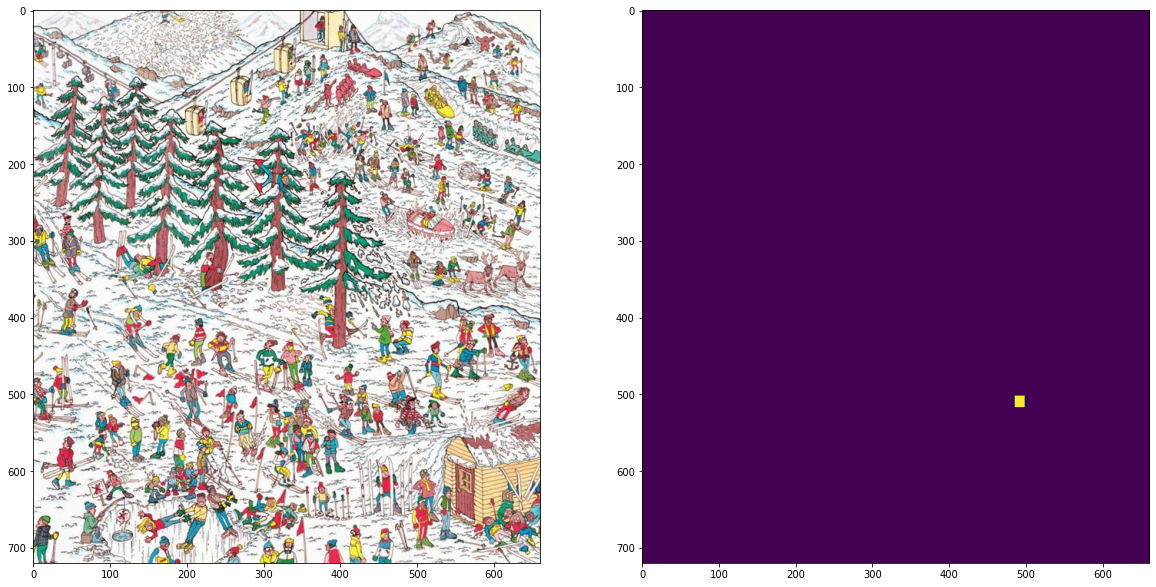

In [30]:
fname_rdm = random.choice(list(df_annotations["filename"].unique()))

fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm))
np_im = np.array(im)
plt.imshow(np_im)

plt.subplot(1, 2, 2)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm.split(".jpg")[0] + "_gt.png"))
np_gt = np.array(gt)[:, :, 0]
plt.imshow(np_gt)

cmpt_zeros = np.sum((np_gt == 0).astype(int))
cmpt_non_zeros = np.sum((np_gt != 0).astype(int))
print("Number of zeros: {}.".format(cmpt_zeros))
print("Number of non zeros: {}.".format(cmpt_non_zeros))
print("Class balance: {} %.".format(round(cmpt_non_zeros * 100. / cmpt_zeros, 3)))

plt.show()

Closer look at our target...

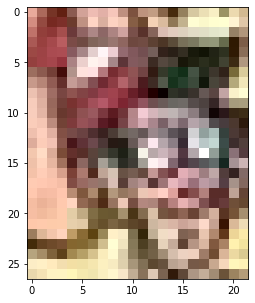

In [40]:
fname_rdm = random.choice(list(df_annotations["filename"].unique()))
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm))
np_im = np.array(im)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm.split(".jpg")[0] + "_gt.png")).convert("L")
np_gt = np.array(gt)
np_gt_labeled, n_waldo = label(np_gt, return_num=True)
fig = plt.figure(figsize=(5, 5))
for i_waldo in range(n_waldo):
    gt_cur = (np_gt_labeled == i_waldo+1).astype(int)
    coords = find_bounding_box_coords(gt_cur)
    plt.subplot(1, n_waldo, i_waldo+1)
    plt.imshow(np_im[coords[0]:coords[1], coords[2]:coords[3]])
plt.show()

## Step 2: Training data loading

We are now splitting our dataset between training and validation. The validation dataset plays a key role in monitoring model overfitting. This subset is independent from the training set. The training set is used to optimise the model weights, while the validation set is used to track the model performance.

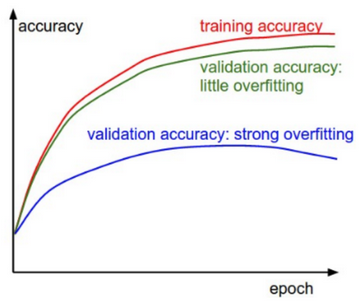

In [41]:
print("Splitting dataset between Training / Validation / Testing...")
df_fname = df_annotations.drop_duplicates("filename")["filename"]
df_fname_train, df_fname_validate = \
    np.split(df_fname.sample(frac=1, random_state=int_seed_split), [int(ratio_train_dataset*len(df_fname))])
df_annotations["subset"] = "training"
df_annotations.loc[df_annotations["filename"].isin(df_fname_validate), "subset"] = "validation"

print(df_annotations.head())

Splitting dataset between Training / Validation / Testing...
  filename  width  height  class  xmin  ymin  xmax  ymax      subset
0  001.jpg   2048    1251  waldo   706   513   743   562    training
1  002.jpg   1286     946  waldo    82   521   107   554    training
2  003.jpg   2048    1346  waldo  1390   463  1422   500    training
3  004.jpg   2048    1272  waldo  1484   279  1507   306  validation
4  005.jpg   2100    1760  waldo   882   594   913   634    training


Number of images used for training vs. validation.

In [42]:
print(len(df_annotations[df_annotations["subset"] == "training"]["filename"].unique()), len(df_annotations[df_annotations["subset"] == "validation"]["filename"].unique()))

28 7


Now the data loaders, one for the training set, one for the validation set. We are selecting the images for each set and generating a dataset for each.

Two important things are implemented in this WaldoLoader:
- patch extraction: the original images are too large for model training. We are performing a patch extraction, controlled by the "size_patch" parameter, with a random sliding window selection.
- positive patch extraction: positive patches (ie including Wally's head) are fetched. They will be used to mitigate the high class imbalance of our network.

In [43]:
list_fname_train = df_annotations[df_annotations["subset"] == "training"]["filename"].unique()
list_path_img_train = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_train])
list_path_gt_train = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_train])
dataset_train = WaldoLoader(list_path_img=list_path_img_train,
                            list_path_gt=list_path_gt_train,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=sequence_data_augmentation)

Loading images ...
Resizing image dimensions so that they are a multiple of the patch size: 160 x 160 pixels^2 ...


Same thing with the validation images.
Note: we are not performing data augmentation ("sequence_transforms") on the validation set.

In [44]:
list_fname_valid = df_annotations[df_annotations["subset"] == "validation"]["filename"].unique()
list_path_img_valid = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_valid])
list_path_gt_valid = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_valid])
dataset_valid = WaldoLoader(list_path_img=list_path_img_valid,
                            list_path_gt=list_path_gt_valid,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=None)

Loading images ...
Resizing image dimensions so that they are a multiple of the patch size: 160 x 160 pixels^2 ...


Number of patches (without data augmentation) for each set...

In [45]:
len(dataset_train), len(dataset_valid)

(3163, 638)

Here after, we are checking our positive patches. It is useful to optimise our "size_patch" parameter: we do not want Wally's head to be cut etc.

(160, 160, 3)


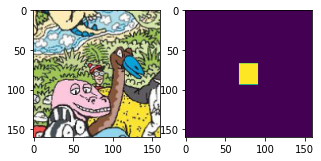

(160, 160, 3)


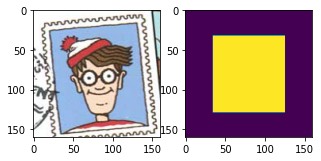

(160, 160, 3)


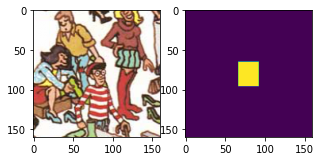

(160, 160, 3)


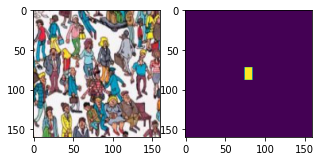

(160, 160, 3)


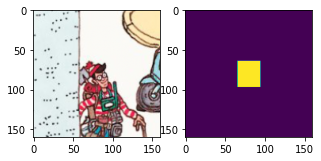

(160, 160, 3)


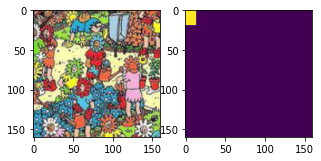

(160, 160, 3)


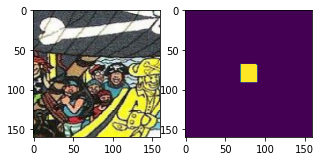

(160, 160, 3)


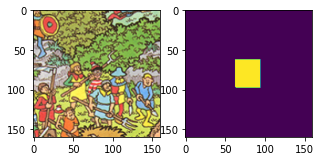

In [46]:
for i, g in zip(dataset_valid.list_patch_positive_img, dataset_valid.list_patch_positive_gt):
  fig = plt.figure(figsize=(5, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(i)
  plt.subplot(1, 2, 2)
  plt.imshow(g)
  print(i.shape)
  plt.show()

Now let's look at the data augmentation transforms. Random Horizontal Flip...

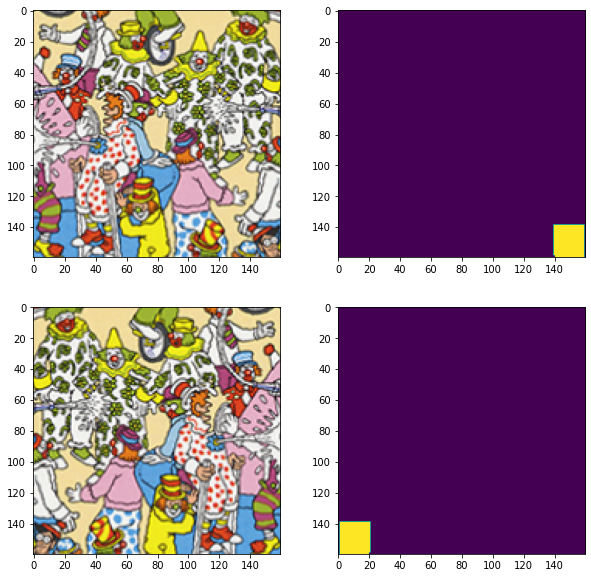

In [47]:
n_sample_positive = len(dataset_train.list_patch_positive_img)
idx_rdm_positive = np.random.randint(0, n_sample_positive-1)
sample = dataset_train.list_patch_positive_img[idx_rdm_positive]
sample_gt = dataset_train.list_patch_positive_gt[idx_rdm_positive]

flip = Sequence([RandomHorizontalFlip()], probs=1)
sample_flip, sample_gt_flip = flip(sample, sample_gt)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(sample)
plt.subplot(2, 2, 2)
plt.imshow(sample_gt)
plt.subplot(2, 2, 3)
plt.imshow(sample_flip)
plt.subplot(2, 2, 4)
plt.imshow(sample_gt_flip)
plt.show()

And the Random Translation. Have a play around with the "translate" parameter and observe what happens...

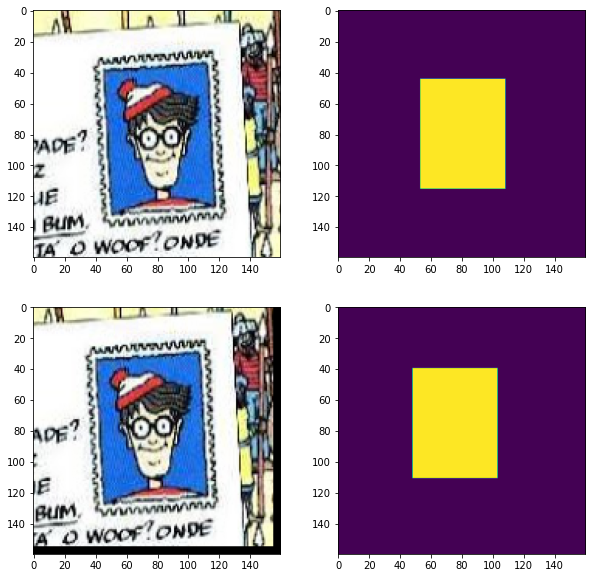

In [48]:
n_sample_positive = len(dataset_train.list_patch_positive_img)
idx_rdm_positive = np.random.randint(0, n_sample_positive-1)
sample = dataset_train.list_patch_positive_img[idx_rdm_positive]
sample_gt = dataset_train.list_patch_positive_gt[idx_rdm_positive]

translate = Sequence([RandomTranslate(translate=0.2)], probs=1)
sample_translate, sample_gt_translate = translate(sample, sample_gt)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(sample)
plt.subplot(2, 2, 2)
plt.imshow(sample_gt)
plt.subplot(2, 2, 3)
plt.imshow(sample_translate)
plt.subplot(2, 2, 4)
plt.imshow(sample_gt_translate)
plt.show()

Converting our Wally Loader to a PyTorch Loader...

In [49]:
loader_train = DataLoader(dataset_train, batch_size=size_batch, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=size_batch, shuffle=True)

Looking at one batch, its size is controlled by the "size_batch" parameter, with the following dimensions: size_batch x n_channels x size_patch x size_patch.

The image intensities have been standardised, i.e., mean centered and reduced standard variation.

In [51]:
image_expl, label_expl = iter(loader_train).next()
print(label_expl.size(), image_expl.size())
print(image_expl.mean(), image_expl.std())
print(label_expl.unique())

torch.Size([16, 1, 160, 160]) torch.Size([16, 3, 160, 160])
tensor(-2.9802e-10) tensor(1.0000)
tensor([0, 1])


## Step 3: Model training

Creating the Waldo Unet instance...

In [52]:
model = Waldo_UNet(n_channels=3).cuda()

Let's look at its skeleton...

In [58]:
model

Waldo_UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, 

The optimizer here after is an important component of the model optimisation process. Model builders are fine-tuning this compoenent to reach optimal training.

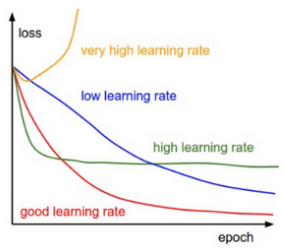

In [53]:
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.01)

Here we are, about to start the training of "n_epoch" epochs.

In [54]:
model_trained = train_model(model,optimizer, loader_train, dataset_validation=loader_valid, n_epoch=n_epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch#1 -- Train loss: -0.019 -- Validation loss: -0.0
Epoch#2 -- Train loss: -0.005 -- Validation loss: -0.007


And now the waiting starts :-) Patience is a virtue, used to say my Granny.. oh well..
Takes hours.. days.. We don't have the time for this right now... but few points:
- Important to monitor the train and validation loss along the way
- You may want to stop your training, change the learning rate and fine tune parameters etc.

In [55]:
#optimizer = update_optimizer(optimizer, lr=0.001)
#model_trained = train_model(model_trained, optimizer, loader_train, dataset_validation=loader_valid, n_epoch=100)

Geeezz ... after days of training... I better save it...

In [56]:
torch.save(model_trained, fname_trained_model)

## Step 4: Inference on independent data

A trained model is provided in the Github repository, let's load it and see how it goes...

In [57]:
pretrained_model = load_andy_model()

Loading pretrained model ...


Now loading a testing image...
The testing images were not including in the previous dataset, that's independent data, located in "dataset/images_test" folder.

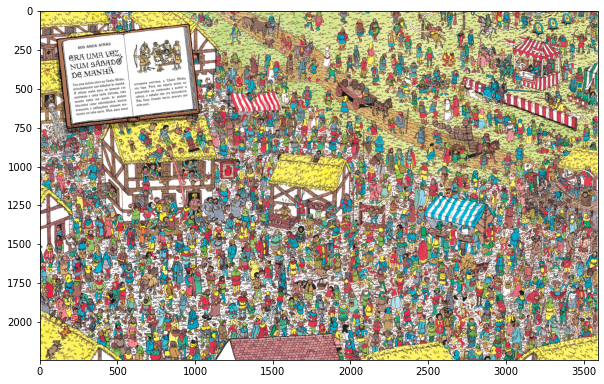

In [59]:
from loader import load_image
fname_rdm_test_image = random.choice([os.path.join(path_dataset_folder, "images_test", i) for i in os.listdir(os.path.join(path_dataset_folder, "images_test")) if i.endswith(".jpg")])
image_test = load_image(fname_rdm_test_image)

plt.figure(figsize=(10, 10))
plt.imshow(image_test)
plt.show()

We resize the image, extract patches, run the model on them, reconstruct the full-sized prediction.

In [60]:
image_test_resized, predictions, predictions_alpha = predict_with_pretrained_model(image_test, pretrained_model)

Resizing input image ...
Extracting patches ...
Running predictions ...


Now visualising the results...
Looks like the model found 2 candidates...

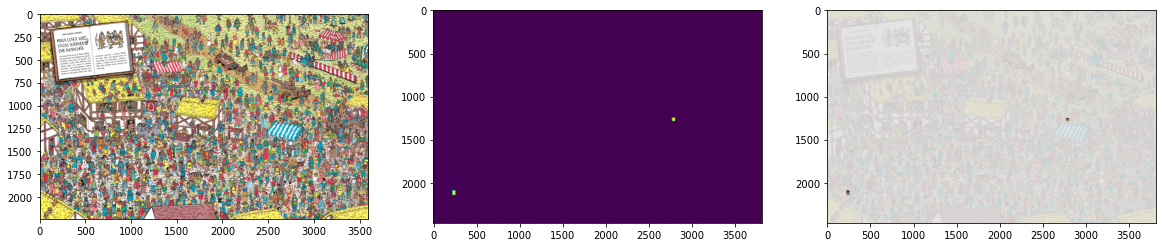

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(image_test)
plt.subplot(1, 3, 2)
plt.imshow(predictions)
plt.subplot(1, 3, 3)
plt.imshow(predictions_alpha)
plt.show()

Let's have a closer look at these candidates...
Ouiiii we have Wallyyyy ... and Wanda... Oh well :-)

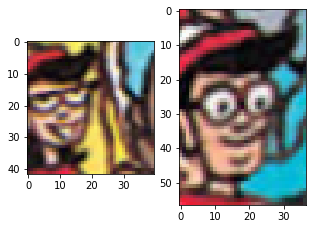

In [ ]:
predictions_thr = threshold_mask(predictions, 0.5)
np_pred_labeled, n_waldo = label(predictions_thr, return_num=True)
fig = plt.figure(figsize=(5, 5))
for i_waldo in range(n_waldo):
    pred_cur = (np_pred_labeled == i_waldo+1).astype(int)
    coords = find_bounding_box_coords(pred_cur)
    plt.subplot(1, n_waldo, i_waldo+1)
    plt.imshow(image_test_resized[coords[0]:coords[1], coords[2]:coords[3]])
plt.show()

## Perspectives


This approach is far for being perfect. It is a simple first iteration to tackle this challenge.

Here after some avenues:
- as a detection task (bounding box) rather than a semantic segmentation task
- use pre-trained models, e.g. [Faster R-CNN](https://pytorch.org/vision/stable/models.html#torchvision.models.detection.fasterrcnn_resnet50_fpn).

Have fun :-)